In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import plot, draw, show
from scipy.linalg import lu
import scipy.linalg as la
import random
import simpy
import math
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

def plotpretify(ax, maxx, minx=0, miny=None, maxy=None,
                Grid=True, LB=True, LL=True):
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=True)
    ax.grid(True)
    
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

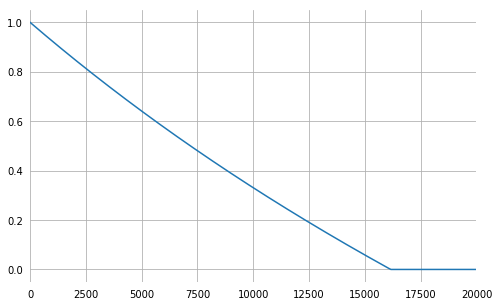

At iteration 16294
finished
Final score = 32.45500987483133


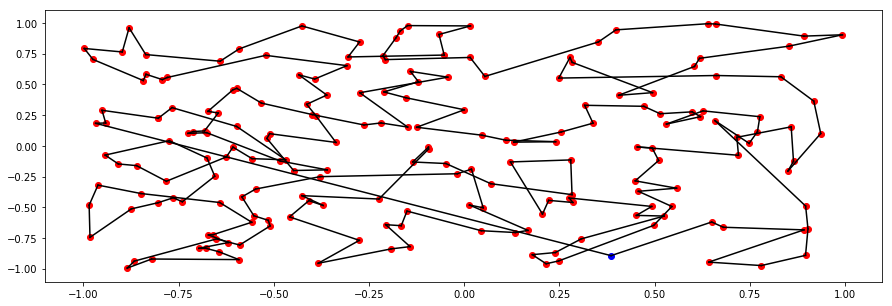

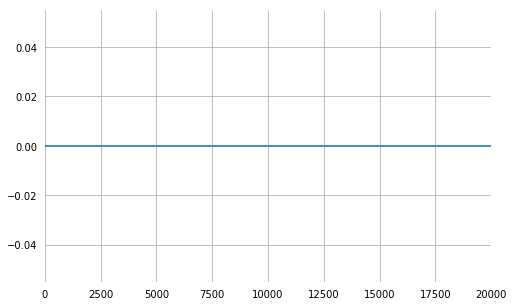

At iteration 687
finished
Final score = 34.72198698128651


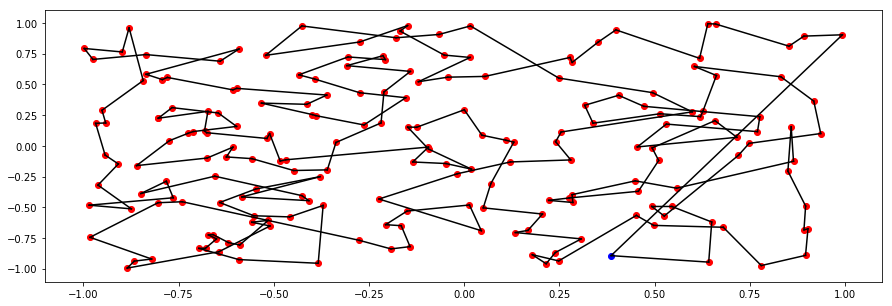

In [6]:
import numpy as np
import scipy.spatial as sp
import matplotlib.pyplot as plt
import tkinter


def getScheme_data(iters, plot="No", scheme="Sigmoid"):

    answer = []

    if scheme == "Sigmoid":
        linspace = np.linspace(0, 9, iters)
        for x in linspace:
            answer.append(0.5 +
                          math.erf((math.sqrt(math.pi) / 2) * (x - 2)) * -0.5)
    elif scheme == "Exp":
        for x in range(iters):
            answer.append(np.exp(-x / iters))
    elif scheme == "Expvar":
        for x in range(iters):
            answer.append(
                max(
                    np.exp(-x / iters) - ((1.5 * x) / iters) * (1 / math.e),
                    0))
    elif scheme == "Hillclimb":
        for x in range(iters):
            answer.append(0)
    elif scheme == "Binary":
        for x in range(iters):
            if x < iters / 2:
                answer.append(1)
            else:
                answer.append(0)

    if plot == "Yes":
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(answer, label="Acceptance chance")
        plotpretify(ax, iters)
        plt.show()
    return np.array(answer)

def spawn(n):
    pointsdict = {}
    points = []
    for i in range(n):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        p = [x, y]
        pointsdict[i] = p
        points.append(i)
    return points, pointsdict

def scorecalc(n, points, pointsdict):
    difs = 0
    for i in range(n - 1):
        a = pointsdict[points[i]]
        b = pointsdict[points[i + 1]]
        dif =  sp.distance.euclidean(a, b)
        difs += dif
    a = pointsdict[n - 1]
    b = pointsdict[0]
    dif =  sp.distance.euclidean(a, b)
    difs += dif
    return difs


def anneal(n, points, pointsdict, score, temp, tr):
    b1 = np.random.randint(1, n)
    nnn = max(2, int(temp * n))
    b2 = b1 + np.random.randint(2, n)
    new = np.concatenate((np.array(points[:b1], int), np.array(points[b1:b2][::-1], int), np.array(points[b2:], int)))
    # print(new)
    newscore = scorecalc(n, new, pointsdict)
    # print(newscore)
    if newscore < score:
        # print("Score is better")
        return new, newscore, False
    elif np.random.uniform(0, 1) < temp:
        # print("Score got accepted with luck")
        return new, newscore, False
    elif tr != 0:
        # print(tr)
        return anneal(n, points, pointsdict, score, temp, tr - 1)
    return points, score, True

def tempcalc(temp):
    return temp * 0.7

def plot(n, points, pointsdict):
    x = []
    y = []
    for i in pointsdict:
        x.append(pointsdict[i][0])
        y.append(pointsdict[i][1])
    plt.scatter(x[1:], y[1:], color="red")
    plt.scatter(x[0], y[0], color="blue")
    for i in range(n - 1):
        a = pointsdict[points[i]]
        b = pointsdict[points[i + 1]]
        x = [a[0], b[0]]
        y = [a[1], b[1]]
        plt.plot(x, y, color="black")
    a = pointsdict[points[n - 1]]
    b = pointsdict[points[0]]
    x = [a[0], b[0]]
    y = [a[1], b[1]]
    plt.plot(x, y, color="black")
    plt.show()
        


def run(n, iterations, scheme, markovChain, plotScheme="No", pointsdict=None, points=None):
    if pointsdict == None:
        print("hoi")
        points, pointsdict = spawn(n)
    # points = [0, 1, 2, 3, 4, 5]
    # pointsdict = {0: [0,0], 1: [2,2], 2: [3,-4], 3: [7,2], 4: [-4,-6], 5: [-4, 6]}
    score = scorecalc(n, points, pointsdict)
    # print(score)
    temp = 1.0
    steps = []
    schemeData = np.repeat(
        getScheme_data(iterations, plot=plotScheme, scheme=scheme),
        markovChain)
    for i in range(iterations):
        temp = schemeData[i]
        points, scorenew, finished = anneal(n, points, pointsdict, score, temp, 800)
        steps.append(points)
        if finished:
            print("At iteration {}".format(i))
            print("finished")
            print("Final score = {}".format(score))
            plot(n, points, pointsdict)
            return points, score, steps, pointsdict
        else:
            score = scorenew
        # print(points)
    print(pointsdict)
    return points, score, steps, pointsdict
   
n = 200
schemes = ["Sigmoid", "Exp", "Expvar", "Hillclimb"]
schemes = ["Expvar", "Hillclimb"]

points, pointsdict = spawn(n)
for scheme in schemes:
    point, score, steps, pointsdict = run(n, 20000, scheme, 1, plotScheme="Yes", pointsdict=pointsdict, points=points)


# point, score, steps, pointsdict = run(n, 10000)

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


def showPlot(i=0):
    plot(n, steps[i], pointsdict)

# for cll in coordListListList:
y = interactive(showPlot, i=(0, len(steps) - 1, 1))
# y = interactive(showPlot, i=range(len(steps)))
# plot(n, steps[-1], pointsdict)
display(y)

interactive(children=(IntSlider(value=0, description='i', max=673), Output()), _dom_classes=('widget-interact'…